In [1]:
from setup import *
from utils import load_data, add_features, add_labels, plot_cumulative_returns, split_data

In [2]:
asset_data = load_data("USDBRL=X", "2020-01-01", "2023-10-01")
asset_data = add_features(add_labels(asset_data))
asset_data.head()

/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/utils.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date, interval="1wk")
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,target,returns,volatility,ma_4,ma_12,ma_ratio
Date,,,,,,,,,,,
2020-03-18,5.1417,5.2105,4.976100,5.009900,0,1,0.028546,0.021153,4.834000,4.434806,1.090014
2020-03-25,5.1927,5.2040,4.973900,5.098600,0,1,0.009919,0.013171,5.014075,4.529165,1.107064
2020-04-01,5.2853,5.3513,5.185842,5.203900,0,0,0.017833,0.005596,5.154675,4.624123,1.114736
2020-04-08,5.1985,5.2447,5.050000,5.221600,0,1,-0.016423,0.024222,5.204550,4.708290,1.105401
2020-04-15,5.3154,5.3173,5.159709,5.160036,0,1,0.022487,0.027514,5.247975,4.800731,1.093162


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())
])

In [5]:
X = asset_data[["ma_ratio", "ma_4", "volatility", "Close"]]
y = asset_data["target"]

X_train, X_test, y_train, y_test = split_data(
    X,
    y
)

In [6]:
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [7]:
predictions = pipeline.predict(X_test)
probas = pipeline.predict_proba(X_test)[:, 1]
predictions = (probas > 0.6).astype(int)

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=["Down", "Up"]))

              precision    recall  f1-score   support

        Down       0.64      0.50      0.56        28
          Up       0.59      0.71      0.65        28

    accuracy                           0.61        56
   macro avg       0.61      0.61      0.60        56
weighted avg       0.61      0.61      0.60        56



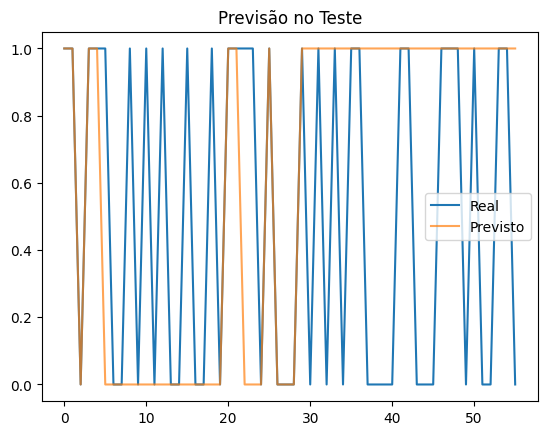

In [9]:
import matplotlib.pyplot as plt

plt.plot(y_test.values, label="Real")
plt.plot(predictions, label="Previsto", alpha=0.7)
plt.legend()
plt.title("Previsão no Teste")
plt.show()

In [10]:
all_predictions = pipeline.predict(X)
all_probas = pipeline.predict_proba(X)[:, 1]
all_predictions = (all_probas > 0.7).astype(int)

asset_data["predicted_target"] = all_predictions
asset_data["real_return"] = asset_data["returns"] * asset_data["predicted_target"]
asset_data.head()

,Close,High,Low,Open,Volume,target,returns,volatility,ma_4,ma_12,ma_ratio,predicted_target,real_return
Date,,,,,,,,,,,,,
2020-03-18,5.1417,5.2105,4.976100,5.009900,0,1,0.028546,0.021153,4.834000,4.434806,1.090014,1,0.028546
2020-03-25,5.1927,5.2040,4.973900,5.098600,0,1,0.009919,0.013171,5.014075,4.529165,1.107064,1,0.009919
2020-04-01,5.2853,5.3513,5.185842,5.203900,0,0,0.017833,0.005596,5.154675,4.624123,1.114736,0,0.000000
2020-04-08,5.1985,5.2447,5.050000,5.221600,0,1,-0.016423,0.024222,5.204550,4.708290,1.105401,0,-0.000000
2020-04-15,5.3154,5.3173,5.159709,5.160036,0,1,0.022487,0.027514,5.247975,4.800731,1.093162,0,0.000000


In [11]:
asset_data["cumulative_real_return"] = (1 + asset_data["returns"]).cumprod()
asset_data["cumulative_predicted_return"] = (1 + asset_data["real_return"]).cumprod()

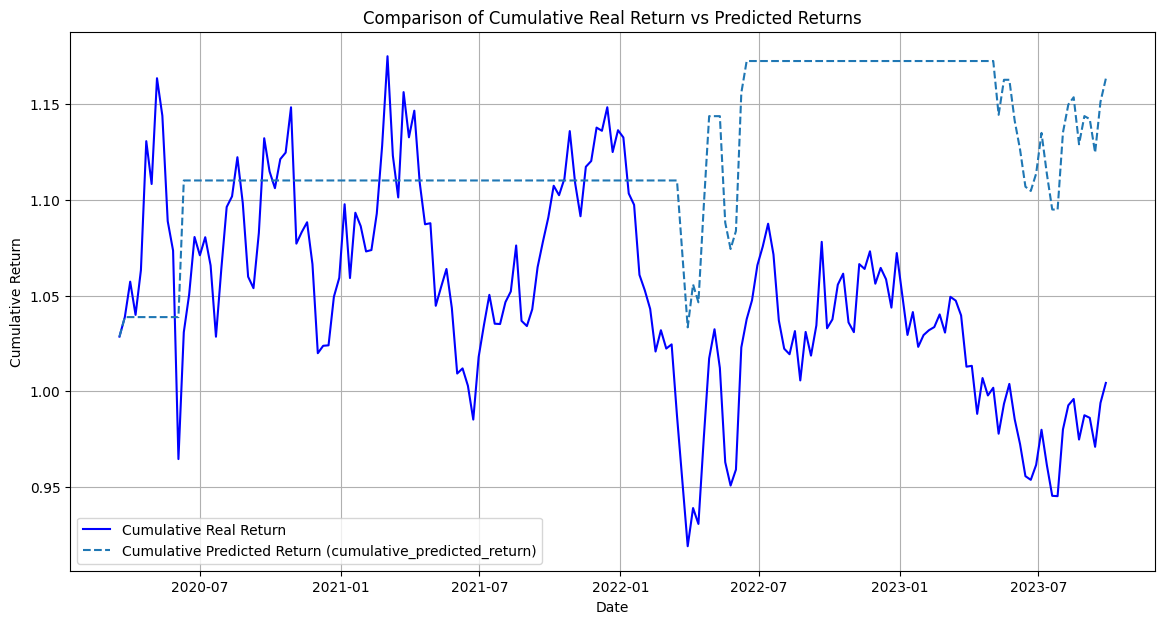

In [12]:
plot_cumulative_returns(
    data=asset_data,
    real_column="cumulative_real_return",
    predicted_columns=["cumulative_predicted_return"]
)